In [2]:
import numpy as np
import matplotlib.pyplot as plt

the posts [[ 100.  100.]
 [ 100. -100.]
 [-100.  100.]
 [-100. -100.]]
test measurement [ 100.          100.          223.60679626  223.60679626]
the loop
actual: [ 1.01252627 -0.16033548]
estim: [ 3.45569253  1.9749161 ]
actual: [ 1.98016047 -0.23530833]
estim: [ 3.34144735 -0.29269737]
actual: [ 2.84196615 -0.30000734]
estim: [ 4.0208416  -0.35752988]
actual: [ 2.88657713  0.79156297]
estim: [ 3.63973117  0.59784544]
actual: [ 3.87193418  0.86586463]
estim: [ 4.49548292  0.65936542]
actual: [ 4.7597971   1.09239864]
estim: [ 5.6133666  0.6299156]
actual: [ 4.84422302  2.09900641]
estim: [ 5.40708971  1.47333026]
actual: [ 5.78738499  2.07181168]
estim: [ 6.05304623  1.38085699]
actual: [ 5.8560133   3.03802538]
estim: [ 6.09242392  2.70309138]
actual: [ 7.00298166  3.03780985]
estim: [ 7.21971178  2.96630001]
actual: [ 7.95186377  2.84952116]
estim: [ 7.87181807  2.88807869]
actual: [ 8.82316208  2.96724653]
estim: [ 8.84313583  2.47428465]
actual: [ 9.70745945  2.75014257]
estim: [ 

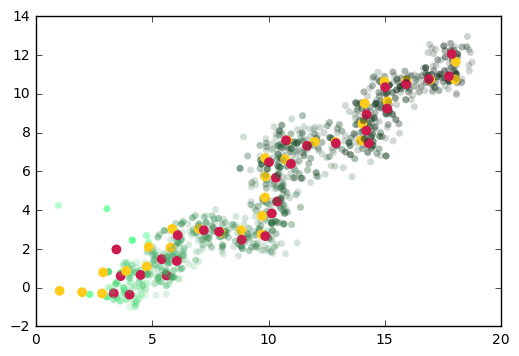

In [147]:
#1. define four posts

posts = [[100,100],[100,-100],[-100,100],[-100,-100]]
posts = np.array(posts,dtype='float32')

print('the posts', posts)

#2. define the bot class
# each bot can be actual or simulated
class bot:
    def __init__(self,state):
        # state is the bot's initial belief of where he is.
        self.state = np.array(state,dtype='float32')
        
    def act(self,action=0,noisy=False):
        # apply action to bot's internal state. e.g, walk towards some direction
        # returns a new bot
        newstate = self.state + action
        if noisy!=False:
            newstate += np.random.normal(loc=0,scale=noisy,size=newstate.shape)
        return bot(newstate)
        
    def measure(self,noisy=False):
        # measure distance to posts
        # self.state -> [dim]
        state = self.state.view()
        state.shape = (1,)+state.shape # expand dimension -> [1,dim]
        
        dists = np.sqrt(np.sum((state - posts)**2,axis=1))
        
        #additive noise on measurements
        if noisy!=False:
            dists += np.random.normal(loc=0,scale=noisy,size=dists.shape)
            
        return dists

#3. test the bot class
b = bot([100,0])
print('test measurement',b.measure())

#4. the loop
print('the loop')

def runloop():
    # a population of bots (particles as in particle filter)
    # sampled from gaussian near the initial position
    N = 50
    
    # create the actual bot
    actual_bot = bot([0,0])
    population = [actual_bot.act(noisy=10.) for i in range(N)]
    plotter = scatter_plotter()
    
    for i in range(30):
        # define action for this step
        walk_right = np.array([1.,0.],dtype='float32')
        walk_up = np.array([0.,1.],dtype='float32')
        
        walk = walk_right if np.random.uniform()>.5 else walk_up
        
        # apply the walking action to all bots in the population, generate a new population
        population = [p.act(action=walk,noisy=.3) for p in population]

        # apply the walking action to the actual bot
        actual_bot = actual_bot.act(action=walk,noisy=.1)

        # ask actual bot to measure the distances to the posts
        actual_measurement = actual_bot.measure(noisy=1.)

        # ask all the particle bots to imaginatively measure the distances, then
        # calculate the likelihood of each particle in the population 
        # l = e ^ (- squared_dist_between_imagined_and_actual / c)

        c = 5. # c is the falloff factor. larger -> slower falloff
        l = [np.exp(-np.sum((p.measure() - actual_measurement)**2)/c) for p in population]
        l = np.array(l)

        # normalize sum to 1.     
        l /= sum(l)

        # resample from the population, weighted using normalized likelihood
        indices = np.random.choice(a=N,p=l,size=N)
        population = [population[idx] for idx in indices]
        
        # estimate from population
        estimated = np.mean([p.state for p in population],axis=0)
        
        # print where the actual bot is
        print('actual:',actual_bot.state)
        print('estim:',estimated)
        
        # print where the population is
        # print('popu.',[p.state for p in population[0:1]])
        plotter.plot(actual_bot,estimated,population)
        
    plotter.show()
    
#5. the plot

class scatter_plotter:
    def __init__(self):
        self.colors = [.4,1.,.6,.2]
        f, ax = plt.subplots() # only one
        #         plt.figure(figsize=(2,2))
        self.ax = ax
        
    def plot(self,actual,estm,popu):
        self.ax.scatter(
            [p.state[0] for p in popu],
            [p.state[1] for p in popu],
            s=25,c=self.colors,edgecolors='none')
        
        self.ax.scatter(
            actual.state[0],actual.state[1],
            s=50,c=(1.,.8,.1),edgecolors='none')
        
        self.ax.scatter(
            estm[0],estm[1],
            s=50,c=(.8,.1,.3),edgecolors='none')
        
        # plt.show()
        self.colors = [c*.94 for c in self.colors]
        self.colors[3] = .2

    def show(self):
        plt.show()
        
runloop()